In [1]:
import os
import numpy as np
from skimage import io
import pandas as pd
import torch
import torchvision as tv
from tqdm.notebook import tqdm, trange

In [2]:
data_dir = 'data'
image_dir = os.path.join(data_dir, 'train')
label_file_path = os.path.join(data_dir, 'train_labels.csv')
label_dict = {row[0]: row[1] for _, row in pd.read_csv(label_file_path).iterrows()}
label_names = ['healthy', 'cancer']

In [3]:
all_file_names = os.listdir(image_dir)
train_file_names = all_file_names[:-256]
valid_file_names = all_file_names[len(train_file_names):]

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, file_names, torch_format=True):
        self.file_names = file_names
        self.torch_format = torch_format
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image = io.imread(os.path.join(image_dir, file_name)).astype(np.float32) / 255
        if self.torch_format:
            image = np.moveaxis(image[32:64, 32:64], -1, 0)
        label = label_dict[file_name.replace('.tif', '')]
        return image, label
    
    def __len__(self):
        return len(self.file_names)
    
    @property
    def labels(self):
        return np.array([label_dict[file_name.replace('.tif', '')] for file_name in self.file_names])

In [5]:
train_dataset = Dataset(train_file_names)
valid_dataset = Dataset(valid_file_names)

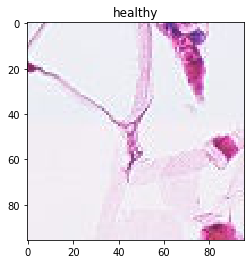

Image shape: (96, 96, 3)
Min value: 0.054901961237192154, max value: 1.0


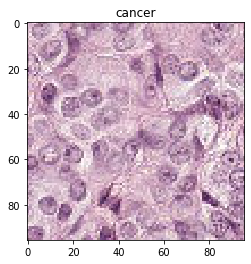

Image shape: (96, 96, 3)
Min value: 0.05882352963089943, max value: 1.0


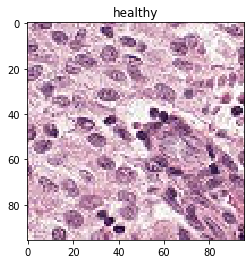

Image shape: (96, 96, 3)
Min value: 0.0, max value: 1.0


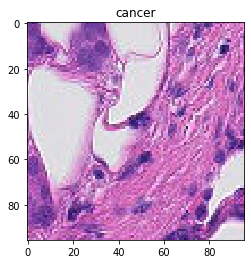

Image shape: (96, 96, 3)
Min value: 0.0235294122248888, max value: 1.0


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for image, label in Dataset(all_file_names[:4], torch_format=False):
    plt.title(label_names[label])
    plt.imshow(image)
    plt.show()
    print(f'Image shape: {image.shape}')
    print(f'Min value: {image.min()}, max value: {image.max()}')

In [7]:
def balance_chart(dataset):
    unique, counts = np.unique(dataset.labels, return_counts=True)
    plt.pie(counts, labels=[label_names[value] for value in unique])
    plt.show()

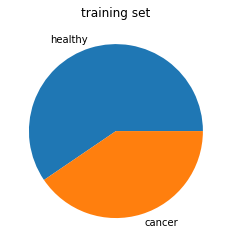

In [8]:
plt.title('training set')
balance_chart(train_dataset)

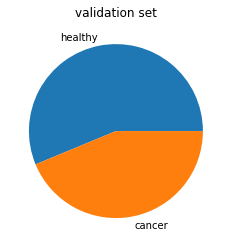

In [9]:
plt.title('validation set')
balance_chart(valid_dataset)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, 32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 32, shuffle=True)

In [13]:
cnn = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)

In [14]:
for epoch in trange(8):
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [26]:
from collections import defaultdict

def validate(model):
    result = defaultdict(int)
    for images, labels in tqdm(valid_loader):
        outputs = model(images)
        predictions = (outputs[:, 0] < outputs[:, 1]).data.numpy()
        labels = labels.data.numpy().astype(bool)
        result['tp'] += np.sum(labels & predictions)
        result['fp'] += np.sum(np.logical_not(labels) & predictions)
        result['tn'] += np.sum(np.logical_not(labels) & np.logical_not(predictions))
        result['fn'] += np.sum(labels & np.logical_not(predictions))
    return result

In [27]:
validate(cnn)

defaultdict(int, {'tp': 78, 'fp': 5, 'tn': 139, 'fn': 34})

In [28]:
save_file_path = 'cnn.pth'
torch.save(cnn.state_dict(), save_file_path)